# Predicting the Helpfulness of Amazon Reviews
### Keane Johnson and Tucker Anderson

This notebook builds multiple models that predict the helpfulness of Amazon reviews. It uses the [2015 Amazon Review dataset](http://jmcauley.ucsd.edu/data/amazon/index.html), compiled by Julian McAuley, associate professor in the Computer Science department at the University of California, San Diego.

The dataset contains product reviews from Amazon from May 1996 - July 2014, and includes ratings, text, helpfulness votes, descriptions, category information, price, brand, and image features. It is broken into smaller subsets, organized by product category.

This notebook focuses on the Home and Kitchen sub-category, and uses the aforementioned features to predict helpfulness.

## Outline
- Import Libraries
- Load and Prepare Dataset
- Exploratory Data Analysis
- Model 1: Every review is 100% helpful
- Model 2: Naive Bayes Bag of Words with Binary Helpfulness Labels
- Model 3: TFIDF and Logistic Regression
- Model 4: BERT

## Import Libraries

In [5]:
# load packages
import gzip
import json
import os
import wget

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import random
random.seed(42)

## Load and Prepare Dataset

In [6]:
# load dataset - download directly from source, save to data directory

file_name = "data/reviews_Home_and_Kitchen_5.json.gz"
output_dir = "data"
url = "http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Home_and_Kitchen_5.json.gz"

if not os.path.isdir(output_dir):
    os.makedirs(output_dir)

if not os.path.isfile(file_name):
    file_name = wget.download(url, out=output_dir)

In [184]:
# helper functions to parse data from compressed json into pandas DF
def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield eval(l)

def get_dataframe(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    
    df_return = pd.DataFrame.from_dict(df, orient='index')
    #shuffle all records to reduce bias of order of data
    df_return = df_return.sample(frac=1)
    
    return df_return


# helper function to pull out total helpful votes
def get_helpful_votes(helpful):
    [helpful, total] = helpful
    return helpful


# helper function to pull out total votes (helpful and unhelpful)
def get_total_votes(helpful):
    [helpful, total] = helpful
    return total
    
    
# helper function to calculate helpfulness percentage 
def calculate_helpful_perc(helpful):
    [helpful, total] = helpful
    if total == 0:
        return 0
    else:
        return (helpful/total)
    
def balance_df(df):
    df_non_one = df[df.helpful_perc != 1]
    len_zero = len(df[df.helpful_perc == 0])
    print(len_zero)
    print(len(df[df.helpful_perc == 1]))
    df_one = df[df.helpful_perc == 1].sample(len_zero)
    df = df_non_one.append(df_one, ignore_index=True)
    return df



In [187]:
# create dataframe
df = get_dataframe(file_name)

# parse helpful column into new columns of helpful_votes, total_votes, helpful_perc
df['helpful_votes'] = df['helpful'].apply(get_helpful_votes)
df['total_votes'] = df['helpful'].apply(get_total_votes)
df['helpful_perc'] = df['helpful'].apply(calculate_helpful_perc)


# Now create the combinedText with casing and no longer than 512 characters (max of BERT embedding input)
df['combinedText'] = df['summary'] + ". " + df['reviewText']

#drop rows where not enough votes exist to discern helpfullness
kitchen_df = df.drop(df[df.total_votes < 5].index)
balanced_kitchen_df = balance_df(kitchen_df)

720
23257


## Exploratory Data Analysis

### Data Insights

In [9]:
df.shape

(551682, 12)

The dataset contains 551,682 rows and twelve columns.

In [6]:
df.sample(5)

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,helpful_votes,total_votes,helpful_perc
438202,A1UY3S4OR2ZLK4,B005DN65WG,John L,"[0, 0]",These mattress protector are terrific. Unlike ...,5.0,Terrific Product,1391126400,"01 31, 2014",0,0,0.000000
471318,A30WZ2LGA8VVPR,B0077L8YFI,Jonathan,"[0, 0]","Pros: Really loved the look, it wasn't too dif...",1.0,Was disappointed so I returned it. The weight...,1396310400,"04 1, 2014",0,0,0.000000
68407,ATS3U1L4F89VQ,B0000DE9B8,Diane,"[2, 4]",You really can't go wrong with a glass measuri...,5.0,You Can't Go Wrong,1124409600,"08 19, 2005",2,4,0.500000
401258,A2JSKM60VTCNI,B004CLYAM2,"Paul Stuart ""&#34;...also I'll brush my teeth...","[8, 13]",Reviewer Disclaimer: This was received as a Re...,3.0,"Crisp, clean air in a sleek package...but bett...",1341446400,"07 5, 2012",8,13,0.615385
548589,A1JBBR4MNGQ70G,B00J7XVNAM,Falkor The White Luck Dragon,"[2, 2]",I needed a window air conditioner as the upsta...,5.0,Just What I Was Looking For,1402358400,"06 10, 2014",2,2,1.000000


The twelve columns contain data including the reviewer name and review time, in addition to more applicable data to our models, like review text, summary, and helpful scores. The helpful column is a list of two numbers. The first number is the number of individuals who found that review helpful. The second number is the total number of individuals who scored that review.

We parse out these two numbers in helpful_votes and total_votes. We calculate the helpfulness percentage as well in helpful_perc. This is simply the number of helpful_votes divided by the number of total_votes. Helpful_perc will be our target variable in our models.

There are two sources of natural language in the dataset - reviewText and summary. We assume the reviewText will be more robust and impactful in determining whether a review is helpful or not. However, summary is a good resource for our models as well.

Next, we want to examine the completeness of our dataset.

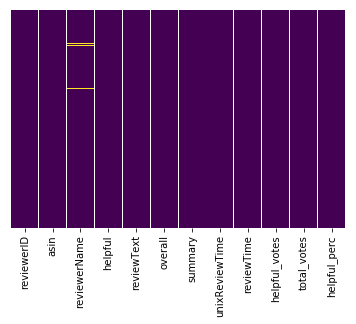

In [7]:
sns.heatmap(df.isnull(),cbar=False,yticklabels=False,cmap = 'viridis')

This heatmap shows that there are missing values for some observations of reviewerName. However, with such a large dataset, we could be missing some values for other features that just do not appear on this chart

In [8]:
missing_df = pd.DataFrame(df.isnull().sum())
missing_df

,0
reviewerID,0
asin,0
reviewerName,4953
helpful,0
reviewText,0
overall,0
summary,0
unixReviewTime,0
reviewTime,0
helpful_votes,0


We confirm that we are only missing values for reviewerName. We reason that this does not have an impact on our analysis because we will be using primarily the reviewText, and possibly the summary, to determine a review's helpfulness. Additionally, we argue that individuals do not consistently use a reviewer's name when determining a review's helpfulness.

### Summary Statistics

After reviewing some sample data, and examining missing values, we next look at some summary statistics of our dataset.

In [9]:
df.describe()

,overall,unixReviewTime,helpful_votes,total_votes,helpful_perc
count,551682.000000,5.516820e+05,551682.000000,551682.000000,551682.000000
mean,4.316655,1.348687e+09,3.497348,3.939469,0.367910
std,1.110749,6.120238e+07,76.539142,77.801556,0.456931
min,1.000000,9.572256e+08,0.000000,0.000000,0.000000
25%,4.000000,1.331770e+09,0.000000,0.000000,0.000000
50%,5.000000,1.367626e+09,0.000000,0.000000,0.000000
75%,5.000000,1.388880e+09,1.000000,2.000000,1.000000
max,5.000000,1.406074e+09,52176.000000,52861.000000,1.000000


These summary statistics show that over half of our observations have a 0% helpfulness. In addition, these observations have zero total votes. This means that the reviews simply haven't been voted upon. We should remove these observations from our dataset because our model could misinterpret the 0% helpful_perc to mean that the review was not helpful when in fact the review just hasn't been voted upon.

### Examining the Target Variable

We can use a histogram to visualize the distribution of helpful percentages.

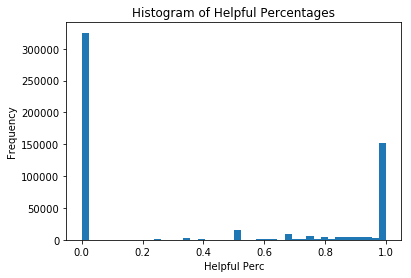

In [10]:
fig1 = plt.figure()
ax1 = fig1.add_subplot(1, 1, 1)
n, bins, patches = ax1.hist(x=df['helpful_perc'], bins='auto')
                                 
ax1.set_xlabel('Helpful Perc')
ax1.set_ylabel('Frequency')
ax1.set_title('Histogram of Helpful Percentages')

This histogram shows that the majority of reviews have a 0% helpful percentage, with the second most prevalent percentage being 100%. However, our dataset needs to be cleaned to remove observations that may add noise, but do not add meaning.

### Data Cleaning

We want to be purposeful with the data that we are supplying to our model. We want to only analyze reviews where there are at least three total votes, or reviews where there are two total votes, but both votes are in agreement.

Our rationale is that two total votes that are split does not tell us much. However, if both are an agreeement, that could tell us something about a reviews helpfulness.

In [14]:
# subset df of reviews that have at least three votes
df_three = df[df.total_votes >= 3]

# subset df of reviews that have two both and both are in agreeement
df_two = df[((df.total_votes == 2) & (df.helpful_perc == 1)) | ((df.total_votes == 2) & (df.helpful_perc == 0))]

# combine the dfs back together
df = df_three.append(df_two, ignore_index=True)
df.shape

(139470, 12)

The size of our dataset is now 139,470 rows. Next we can examine the new distribution of helpful_perc.

In [12]:
df.describe()

,overall,unixReviewTime,helpful_votes,total_votes,helpful_perc
count,139470.000000,1.394700e+05,139470.000000,139470.000000,139470.000000
mean,3.988270,1.301792e+09,13.178676,14.704022,0.848035
std,1.356746,8.137408e+07,151.811710,154.232187,0.242654
min,1.000000,9.572256e+08,0.000000,2.000000,0.000000
25%,3.000000,1.261181e+09,2.000000,3.000000,0.750000
50%,5.000000,1.324080e+09,4.000000,5.000000,1.000000
75%,5.000000,1.362874e+09,9.000000,10.000000,1.000000
max,5.000000,1.405728e+09,52176.000000,52861.000000,1.000000


The median helpful_perc is 100%. We could be at risk of not having a good distribution of data to train on. This could result in our model being overly optimistic and inflating the helpfulness scores of reviews. We can visualize this skew with another histogram.

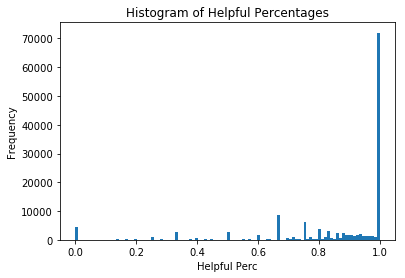

In [13]:
fig2 = plt.figure()
ax2 = fig2.add_subplot(1, 1, 1)
n, bins, patches = ax2.hist(x=df['helpful_perc'], bins='auto')
                                 
ax2.set_xlabel('Helpful Perc')
ax2.set_ylabel('Frequency')
ax2.set_title('Histogram of Helpful Percentages')

## Data Subsetting

Due to resource constraints, we'll subset our data to roughly half the original size. This is still more than enough data to build and test our models.

In [15]:
df_sampled = df.sample(80000)
df_sampled.shape

(80000, 12)

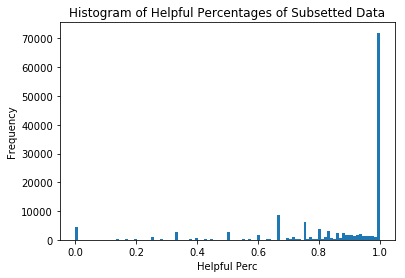

In [15]:
fig3 = plt.figure()
ax3 = fig3.add_subplot(1, 1, 1)
n, bins, patches = ax3.hist(x=df['helpful_perc'], bins='auto')
                                 
ax3.set_xlabel('Helpful Perc')
ax3.set_ylabel('Frequency')
ax3.set_title('Histogram of Helpful Percentages of Subsetted Data')

The distribution of the sampled data visually matches the distribution of the original dataset. We can confirm the distributions are identical with the Kolmogorov-Smirnov statistic.

In [16]:
from scipy.stats import ks_2samp

df_sampled_helpful_prec = df_sampled['helpful_perc']
df_helpful_perc = df['helpful_perc']

ks_2samp(df_sampled_helpful_prec, df_helpful_perc)

Ks_2sampResult(statistic=0.0018642270739226974, pvalue=0.9944665853896963)

In [17]:
# df_sampled becomes our df
df = df_sampled

## Model 1: Every Review is Helpful

The most basic model we can produce is to label each review as being helpful if it meets a certain helpful_perc threshold. We choose 75%.

In [18]:
# calculate total number of reviews
total_reviews = len(df)

# calculate total number of reviews that are at least 75% helpful
helpful_reviews = len(df[df.helpful_perc >= 0.75])

# calculate accuracy if we predicted each review is at least 75% helpful
accuracy_1 = 100*(helpful_reviews/total_reviews)

print("Every Review is Helpful Accuracy Score -> ", accuracy_1)

Every Review is Helpful Accuracy Score ->  79.21125


This model would produce an accuracy score of 79.3%.

## Model 2: Naive Bayes Bag of Words with Binary Helpfulness Labels

A more sophisticated model is one where we estimate the hepfulness of a review using its text. We use a Bag of Words model to determine whether a review is helpful or not. We again define a helpful review as one whose helpfulness percentage is at least 75%.

### Data Pre-Processing

In [19]:
import nltk
# this nltk download may be needed. download stopwords, punkt
# nltk.download()

In [20]:
# ensure there are no missing values in the review or summary text or the overall helpullness percentage
len(df) == len(df.dropna(subset=['reviewText', 'summary', 'helpful_perc']))

True

For our bag of words model, we will combine the reviewText and summary text fields to combine into a single "document" with which to analyze.

In [21]:
#nltk.download()

In [22]:
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords 

stop_words = set(stopwords.words('english'))

def tokenize(text):
    return [word for word in word_tokenize(text) if not word in stop_words]

In [23]:
# We should then tokenize and stem the review data before ingesting into our NLP models
df['combinedText'] = df['summary'].str.lower() + ". " +  df['reviewText'].str.lower()

# Now tokenize these and remove stop words
df['processedText'] = df['combinedText'].apply(tokenize)

In [24]:
# Create new column for helpful reviews (reviews with at least a 75% helpfulness rating)

df["isHelpful"] = df["helpful_perc"] > .75
df["isHelpful"] = df["isHelpful"].apply(int)

In [25]:
#let's make sure everything looks ok
df.sample(5)

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,helpful_votes,total_votes,helpful_perc,combinedText,processedText,isHelpful
106615,A1FNLY02ZH11MW,B00E58P7ME,J. VanGoethem,"[3, 4]","Yes, it costs too much for a $.25 worth of met...",4.0,Does the job,1315699200,"09 11, 2011",3,4,0.750000,"does the job. yes, it costs too much for a $.2...","[job, ., yes, ,, costs, much, $, .25, worth, m...",0
61951,A22MANL4US4RMY,B001V4VMRO,Book Carpenter,"[2, 3]","This cover is a nice, tight fit, and it seems ...",5.0,"Good Fit, Good Construction",1314144000,"08 24, 2011",2,3,0.666667,"good fit, good construction. this cover is a n...","[good, fit, ,, good, construction, ., cover, n...",0
119108,A3NT7RAITJZXXT,B000GX4CKA,"Linda ""cooking enthusiast""","[2, 2]",While this is a good shelf for the price it wo...,3.0,No instructions included,1279929600,"07 24, 2010",2,2,1.000000,no instructions included. while this is a good...,"[instructions, included, ., good, shelf, price...",1
15628,A1VB2KE2PR4J4W,B0000CFNQX,J. J. Emmel,"[3, 4]","It's made in China, a tad small, but not bad f...",3.0,not bad for made in China,1329177600,"02 14, 2012",3,4,0.750000,"not bad for made in china. it's made in china,...","[bad, made, china, ., 's, made, china, ,, tad,...",0
99353,A2QFO64UAU5N18,B008R3ER0Q,"W. Lucas ""wvl""","[2, 4]",This thing is very weak on the suction. I read...,1.0,"Must have gotten a bad one, because",1388361600,"12 30, 2013",2,4,0.500000,"must have gotten a bad one, because. this thin...","[must, gotten, bad, one, ,, ., thing, weak, su...",0


Text(0.5, 1.0, 'Histogram of Helpful/Not Helpful Reviews')

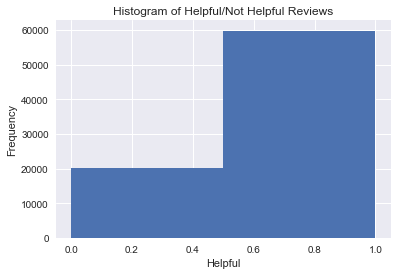

In [26]:
# take a look at distribution of Helpful/Not Helpful

fig4 = plt.figure()
ax4 = fig4.add_subplot(1, 1, 1)
n, bins, patches = ax4.hist(x=df['isHelpful'], bins=2)
                                 
ax4.set_xlabel('Helpful')
ax4.set_ylabel('Frequency')
ax4.set_title('Histogram of Helpful/Not Helpful Reviews')

In [27]:
from sklearn import preprocessing

data = df[['combinedText', 'isHelpful']]

le = preprocessing.LabelEncoder()
preprocessed_data = data.apply(le.fit_transform)

In [26]:
from sklearn.model_selection import train_test_split

Train_X, Test_X, Train_Y, Test_Y = train_test_split(preprocessed_data['combinedText'], 
                                                    preprocessed_data['isHelpful'],
                                                    test_size=0.2)

NameError: name 'preprocessed_data' is not defined

In [29]:
# and train our classifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

g_classifier = GaussianNB().fit(np.array(Train_X.values.tolist()).reshape(-1, 1), Train_Y)
accuracy_2 = accuracy_score(Test_Y, g_classifier.predict(np.array(Test_X.values.tolist()).reshape(-1, 1)))*100

print("Gaussian Naive Bayes Accuracy Score -> ", accuracy_2)

Gaussian Naive Bayes Accuracy Score ->  74.76875


Our Naive Bayes Bag of Words model performs worse than our previous "every review is helpful" baseline model. It produces an accuracy score of 75.3%, down from 79.3%.

## Model 3: TF-IDF and Logistic Regression

In [30]:
# import packages
import sklearn
import string

from sklearn.feature_extraction.text import *
from sklearn.linear_model import LogisticRegression

In [31]:
# split into train/validation/test sets
data = df[['combinedText', 'isHelpful']]

df_train, df_test = train_test_split(data, test_size = 0.2)
df_train, df_val = train_test_split(df_train, test_size = 0.2)

In [32]:
# stem combinedText to reduce size of corpus
from nltk.stem import PorterStemmer

porter=PorterStemmer()

def stem_text(df):
    text_list = df['combinedText'].tolist()
    text_list_stem = [None] * len(text_list)

    for i in range(len(text_list)):
        text_list_stem[i] = ' '.join([porter.stem(w) for w in text_list[i].split()])
    
    return text_list_stem

text_list_stem = stem_text(data)

In [33]:
# vectorize text
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
                max_features=100,
                ngram_range=(1,1)
                )

vectorizer.fit_transform(text_list_stem).toarray()

array([[0.03389221, 0.07340804, 0.03054271, ..., 0.03196743, 0.099017  ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.19454242, 0.        , 0.        , ..., 0.        , 0.14209024,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.26798256,
        0.        ],
       [0.03311168, 0.07171747, 0.08951795, ..., 0.        , 0.145105  ,
        0.14716066],
       [0.        , 0.        , 0.18267261, ..., 0.        , 0.14805248,
        0.        ]])

In [34]:
# vectorize train dataset
train_text_stem = stem_text(df_train)
train_vectorized = vectorizer.transform(train_text_stem).toarray()

print('Shape:', train_vectorized.shape)

Shape: (51200, 100)


In [35]:
# vectorize val dataset
val_text_stem = stem_text(df_val)
val_vectorized = vectorizer.transform(val_text_stem).toarray()

print('Shape:', val_vectorized.shape)

Shape: (12800, 100)


In [36]:
# vectorize test dataset
test_text_stem = stem_text(df_test)
test_vectorized = vectorizer.transform(test_text_stem).toarray()

print('Shape:', test_vectorized.shape)

Shape: (16000, 100)


In [37]:
# create array of labels to use in logistic regression
df_train_labels = np.array(df_train['isHelpful'])
df_test_labels = np.array(df_test['isHelpful'])
df_val_labels = np.array(df_val['isHelpful'])

In [38]:
# train logistic regression
lr = LogisticRegression(penalty='l2')
lr.fit(train_vectorized, df_train_labels)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [39]:
# tune hyperparameters
reg_str = [0.01, 0.1, 1.0, 10, 100, 1000]

best_acc = -1
best_c = None

for r in reg_str:
    lr = LogisticRegression(penalty='l2', C=r)
    lr.fit(train_vectorized, df_train_labels)
    preds = lr.predict(val_vectorized)
    acc = np.mean(preds == df_val_labels)
    print('regularization strength:', r, ' ', 'validation set accuracy:', acc)
    
    if acc > best_acc:
        best_acc = acc
        best_c = r

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


regularization strength: 0.01   validation set accuracy: 0.745546875


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


regularization strength: 0.1   validation set accuracy: 0.746796875


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


regularization strength: 1.0   validation set accuracy: 0.747265625


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


regularization strength: 10   validation set accuracy: 0.7475


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


regularization strength: 100   validation set accuracy: 0.74765625


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


regularization strength: 1000   validation set accuracy: 0.74765625


In [40]:
# test accuracy
lr_final = LogisticRegression(penalty='l2', C = best_c)
lr_final.fit(train_vectorized, df_train_labels)

preds = lr_final.predict(test_vectorized)
accuracy_3 = 100*np.mean(preds == df_test_labels)

print("TF-IDF and Logistic Regression Accuracy Score ->", accuracy_3)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


TF-IDF and Logistic Regression Accuracy Score -> 74.99375


The model with term frequency–inverse document frequency and logistic regression produces a marginally higher accuracy than the Naive Bayes Bag of Words model, but it is still not higher than the rudimentary Every Review is Helpful model. This motivates the need for a more robust representation of the language in the reviews. Enter BERT.

## Model 4: BERT

Code built around Strongio's notebook here https://github.com/strongio/keras-bert/blob/master/keras-bert.ipynb

### Tokenization

In [188]:
import sys
import os
import re

# if this doesnt work, ensure tensorflow is version <2.0
import tensorflow as tf
import tensorflow_hub as hub

from bert.tokenization import FullTokenizer
from tqdm import tqdm_notebook
from tensorflow.keras import backend as K

# Tensorflow hub path to BERT module of choice
BERT_DIR =  "./bert"
BERT_PATH = "https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1"
MAX_SEQ_LENGTH = 128

sys.path.insert(0,BERT_DIR)

# Initialize session, may need to remove config if no GPU
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce GTX 1060 6GB, pci bus id: 0000:01:00.0, compute capability: 6.1



In [247]:
class PaddingInputExample(object):
    """Fake example so the num input examples is a multiple of the batch size.
  When running eval/predict on the TPU, we need to pad the number of examples
  to be a multiple of the batch size, because the TPU requires a fixed batch
  size. The alternative is to drop the last batch, which is bad because it means
  the entire output data won't be generated.
  We use this class instead of `None` because treating `None` as padding
  battches could cause silent errors.
  """

class InputExample(object):
    """A single training/test example for simple sequence classification."""

    def __init__(self, guid, text_a, text_b=None, label=None):
        """Constructs a InputExample.
    Args:
      guid: Unique id for the example.
      text_a: string. The untokenized text of the first sequence. For single
        sequence tasks, only this sequence must be specified.
      text_b: (Optional) string. The untokenized text of the second sequence.
        Only must be specified for sequence pair tasks.
      label: (Optional) string. The label of the example. This should be
        specified for train and dev examples, but not for test examples.
    """
        self.guid = guid
        self.text_a = text_a
        self.text_b = text_b
        self.label = label
        
    def __str__(self):
        return str(self.text_a)

def create_tokenizer_from_hub_module(path):
    """Get the vocab file and casing info from the Hub module."""
    bert_module =  hub.Module(path)
    tokenization_info = bert_module(signature="tokenization_info", as_dict=True)
    vocab_file, do_lower_case = sess.run(
        [
            tokenization_info["vocab_file"],
            tokenization_info["do_lower_case"],
        ]
    )

    return FullTokenizer(vocab_file=vocab_file, do_lower_case=do_lower_case)

def convert_single_example(tokenizer, example, max_seq_length=256, tokenb=True):
    """Converts a single `InputExample` into a single `InputFeatures`."""

    if isinstance(example, PaddingInputExample):
        input_ids = [0] * max_seq_length
        input_mask = [0] * max_seq_length
        segment_ids = [0] * max_seq_length
        label = 0
        return input_ids, input_mask, segment_ids, label

    tokens_a = tokenizer.tokenize(example.text_a)
    if tokenb:
        tokens_b = tokenizer.tokenize(example.text_b)
    else:
        tokens_b = []
    
    if len(tokens_a) > max_seq_length - 2:
        tokens_a = tokens_a[0 : (max_seq_length - 2)]

    elif (len(tokens_a)+len(tokens_b)) > max_seq_length - 3:
        tokens_b = tokens_b[0 : (max_seq_length - 3 - len(tokens_a))]
        
    tokens = []
    segment_ids = []
    tokens.append("[CLS]")
    segment_ids.append(0)
    
    for token in tokens_a:
        tokens.append(token)
        segment_ids.append(0)
    tokens.append("[SEP]")
    segment_ids.append(0)

    if tokenb:
        if len(tokens) < max_seq_length:
            for token in tokens_b:
                tokens.append(token)
                segment_ids.append(1)
            tokens.append("[SEP]")
            segment_ids.append(1)
    
    input_ids = tokenizer.convert_tokens_to_ids(tokens)

    # The mask has 1 for real tokens and 0 for padding tokens. Only real
    # tokens are attended to.
    input_mask = [1] * len(input_ids)

    # Zero-pad up to the sequence length.
    while len(input_ids) < max_seq_length:
        input_ids.append(0)
        input_mask.append(0)
        segment_ids.append(0)

    assert len(input_ids) == max_seq_length
    assert len(input_mask) == max_seq_length
    assert len(segment_ids) == max_seq_length

    return input_ids, input_mask, segment_ids, example.label

def convert_examples_to_features(tokenizer, examples, max_seq_length=256):
    """Convert a set of `InputExample`s to a list of `InputFeatures`."""

    input_ids, input_masks, segment_ids, labels = [], [], [], []
    for example in tqdm_notebook(examples, desc="Converting examples to features"):
        input_id, input_mask, segment_id, label = convert_single_example(
            tokenizer, example, max_seq_length, tokenb=False
        )
        input_ids.append(input_id)
        input_masks.append(input_mask)
        segment_ids.append(segment_id)
        labels.append(label)
    return (
        np.array(input_ids),
        np.array(input_masks),
        np.array(segment_ids),
        np.array(labels).reshape(-1, 1),
    )

def convert_text_to_examples2(titles, labels, texts=None, max_examples=None):
    """Create InputExamples"""
    InputExamples = []
    for title, label in zip(titles, labels):
        InputExamples.append(
            InputExample(guid=None, text_a=title, text_b=None, label=label)
        )
    return InputExamples[:max_examples]

def convert_text_to_examples(titles, texts, labels, max_examples=None):
    """Create InputExamples"""
    InputExamples = []
    for title, text, label in zip(titles, texts, labels):
        InputExamples.append(
            InputExample(guid=None, text_a=title, text_b=text, label=label)
        )
    return InputExamples[:max_examples]

In [190]:
# Instantiate tokenizer
tokenizer = create_tokenizer_from_hub_module(BERT_PATH)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [191]:
# create dataframe
df = get_dataframe(file_name)

# parse helpful column into new columns of helpful_votes, total_votes, helpful_perc
df['helpful_votes'] = df['helpful'].apply(get_helpful_votes)
df['total_votes'] = df['helpful'].apply(get_total_votes)
df['helpful_perc'] = df['helpful'].apply(calculate_helpful_perc)


# Now create the combinedText with casing and no longer than 512 characters (max of BERT embedding input)
df['combinedText'] = df['summary'] + ". " + df['reviewText']

#drop rows where not enough votes exist to discern helpfullness
kitchen_df = df.drop(df[df.total_votes < 5].index)
balanced_kitchen_df = balance_df(kitchen_df)

720
23257


In [194]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(balanced_kitchen_df, test_size = 0.2)
df_train, df_val = train_test_split(df_train, test_size = 0.2)

In [195]:
# Convert data to InputExample format, ensure we don't have too many examples to encounter memory issues
train_examples = convert_text_to_examples(df_train['summary'], df_train['reviewText'], df_train['helpful_perc'], max_examples=1000)
val_examples = convert_text_to_examples(df_val['summary'], df_val['reviewText'], df_val['helpful_perc'], max_examples=200)
test_examples = convert_text_to_examples(df_test['summary'], df_test['reviewText'], df_test['helpful_perc'], max_examples=200)

#make sure the test Y is the same format
test_actual = np.array(df_test['helpful_perc'][:200])
test_actual = test_actual.reshape(-1,1)

# Convert to features
(train_input_ids, train_input_masks, train_segment_ids, train_labels 
) = convert_examples_to_features(tokenizer, train_examples, max_seq_length=MAX_SEQ_LENGTH)
(val_input_ids, val_input_masks, val_segment_ids, val_labels 
) = convert_examples_to_features(tokenizer, val_examples, max_seq_length=MAX_SEQ_LENGTH)
(test_input_ids, test_input_masks, test_segment_ids, test_labels
) = convert_examples_to_features(tokenizer, test_examples, max_seq_length=MAX_SEQ_LENGTH)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:105: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [259]:
bert_df = df_train

bert_df['isHelpful'] = 

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,helpful_votes,total_votes,helpful_perc,combinedText
28393,A1JJOV69MAU2J2,B00004OCK0,Steven Dennis,"[6, 7]",These tongs are cleverly designed and solidly ...,5.0,The best pair of tongs at a bargain price...,999820800,"09 7, 2001",6,7,0.857143,The best pair of tongs at a bargain price.... ...
27884,A1MAKVM3ATO1DC,B008BDSBEU,Kaylie,"[25, 26]",I was skeptical to buy this because I was worr...,5.0,Beautiful!!!!,1358985600,"01 24, 2013",25,26,0.961538,Beautiful!!!!. I was skeptical to buy this bec...
33598,A18H3X0XGMD1K0,B007D3V00Q,NaN,"[1, 5]",I have not used this press because it will be ...,3.0,Will be difficult to clean,1369785600,"05 29, 2013",1,5,0.200000,Will be difficult to clean. I have not used th...
43366,A14CPE16HGLDW2,B005SI8YZC,"Sam Mercer ""Sam""","[6, 8]","Steam blown. Wow, this thing really gets hot....",5.0,My mind is blown,1355788800,"12 18, 2012",6,8,0.750000,"My mind is blown. Steam blown. Wow, this thin..."
2943,A2CGJON31CMTCR,B0049SHD7C,silverorchid,"[6, 9]",I have had several waffle makers. Since most o...,3.0,Average product with few flaws,1364428800,"03 28, 2013",6,9,0.666667,Average product with few flaws. I have had sev...
12726,A15FA4XWUDLMI7,B0000CFOIH,"W. Peterson ""creative cook""","[4, 5]",I really like using this for those special lit...,5.0,Nice little tool for the kitchen,1233100800,"01 28, 2009",4,5,0.800000,Nice little tool for the kitchen. I really lik...
26378,A1TS45JWJVOSSW,B0016LQ01K,"Duane Sparks ""Duane""","[7, 8]","Cooks and cleans perfectly, and has already be...",5.0,Perfect product,1314230400,"08 25, 2011",7,8,0.875000,"Perfect product. Cooks and cleans perfectly, a..."
4133,A1Z54EM24Y40LL,B00004SGFS,csm,"[8, 9]","If you're bored some day, buy these attachment...",5.0,Awesome attachment!,1104451200,"12 31, 2004",8,9,0.888889,"Awesome attachment!. If you're bored some day,..."
23521,A3Q20W5LJTGC7T,B00164W8HM,swrobel,"[14, 18]","Well, I think for once the old adage ""you get ...",4.0,You get more than what you pay for,1243900800,"06 2, 2009",14,18,0.777778,"You get more than what you pay for. Well, I th..."
9833,A3HNW0MW20ZIXF,B0001KOA4Q,"Dominika Lepak ""nikatoo""","[104, 116]","For the price, I'd give the espresso making pa...",4.0,"Great espresso, poor steaming wand",1111968000,"03 28, 2005",104,116,0.896552,"Great espresso, poor steaming wand. For the pr..."


### Neural Net Creation

In [ ]:
class BertLayer(tf.keras.layers.Layer):
    def __init__(
        self,
        n_fine_tune_layers=10,
        pooling="first",
        bert_path="https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1",
        **kwargs,
    ):
        self.n_fine_tune_layers = n_fine_tune_layers
        self.trainable = True
        self.output_size = MAX_SEQ_LENGTH
        self.pooling = pooling
        self.bert_path = bert_path
        if self.pooling not in ["first", "mean"]:
            raise NameError(
                f"Undefined pooling type (must be either first or mean, but is {self.pooling}"
            )

        super(BertLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.bert = hub.Module(
            self.bert_path, trainable=self.trainable, name=f"{self.name}_module"
        )

        # Remove unused layers
        trainable_vars = self.bert.variables
        if self.pooling == "first":
            trainable_vars = [var for var in trainable_vars if not "/cls/" in var.name]
            trainable_layers = ["pooler/dense"]

        elif self.pooling == "mean":
            trainable_vars = [
                var
                for var in trainable_vars
                if not "/cls/" in var.name and not "/pooler/" in var.name
            ]
            trainable_layers = []
        else:
            raise NameError(
                f"Undefined pooling type (must be either first or mean, but is {self.pooling}"
            )

        # Select how many layers to fine tune
        for i in range(self.n_fine_tune_layers):
            trainable_layers.append(f"encoder/layer_{str(11 - i)}")

        # Update trainable vars to contain only the specified layers
        trainable_vars = [
            var
            for var in trainable_vars
            if any([l in var.name for l in trainable_layers])
        ]

        # Add to trainable weights
        for var in trainable_vars:
            self._trainable_weights.append(var)

        for var in self.bert.variables:
            if var not in self._trainable_weights:
                self._non_trainable_weights.append(var)

        super(BertLayer, self).build(input_shape)

    def call(self, inputs):
        inputs = [K.cast(x, dtype="int32") for x in inputs]
        input_ids, input_mask, segment_ids = inputs
        bert_inputs = dict(
            input_ids=input_ids, input_mask=input_mask, segment_ids=segment_ids
        )
        if self.pooling == "first":
            pooled = self.bert(inputs=bert_inputs, signature="tokens", as_dict=True)[
                "pooled_output"
            ]
        elif self.pooling == "mean":
            result = self.bert(inputs=bert_inputs, signature="tokens", as_dict=True)[
                "sequence_output"
            ]

            mul_mask = lambda x, m: x * tf.expand_dims(m, axis=-1)
            masked_reduce_mean = lambda x, m: tf.reduce_sum(mul_mask(x, m), axis=1) / (
                    tf.reduce_sum(m, axis=1, keepdims=True) + 1e-10)
            input_mask = tf.cast(input_mask, tf.float32)
            pooled = masked_reduce_mean(result, input_mask)
        else:
            raise NameError(f"Undefined pooling type (must be either first or mean, but is {self.pooling}")

        return pooled

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_size)
    
    def get_config(self):
        config = {'n_fine_tune_layers': self.n_fine_tune_layers,
                  'pooling': self.pooling,
                  'bert_path': self.bert_path}
        base_config = super(MyMeanPooling, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [213]:
from tensorflow.keras import regularizers

# Build model
def build_model(max_seq_length, model_loss, reg=False): 

    in_id = tf.keras.layers.Input(shape=(max_seq_length,), name="input_ids")
    in_mask = tf.keras.layers.Input(shape=(max_seq_length,), name="input_masks")
    in_segment = tf.keras.layers.Input(shape=(max_seq_length,), name="segment_ids")
    bert_inputs = [in_id, in_mask, in_segment]

    bert_output = BertLayer(n_fine_tune_layers=3, pooling="first")(bert_inputs)
    if reg:
        dense = tf.keras.layers.Dense(max_seq_length, activation='relu', kernel_regularizer=regularizers.l2(0.01))(bert_output)
    else:
        dense = tf.keras.layers.Dense(max_seq_length, activation='relu')(bert_output)
    pred = tf.keras.layers.Dense(1, activation='sigmoid')(dense)

    model = tf.keras.models.Model(inputs=bert_inputs, outputs=pred)
    model.compile(loss=model_loss, optimizer='adam')
    model.summary()
    
    return model

# Build model without explicit bert layer
def build_model_bert(max_seq_length, model_loss, reg=False): 

    in_id = tf.keras.layers.Input(shape=(max_seq_length,), name="input_ids")
    in_mask = tf.keras.layers.Input(shape=(max_seq_length,), name="input_masks")
    in_segment = tf.keras.layers.Input(shape=(max_seq_length,), name="segment_ids")
    bert_inputs = [in_id, in_mask, in_segment]
    
    x = tf.keras.layers.concatenate(bert_inputs)
    
    if reg:
        dense = tf.keras.layers.Dense(max_seq_length, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    else:
        dense = tf.keras.layers.Dense(max_seq_length, activation='relu')(x)
    pred = tf.keras.layers.Dense(1, activation='sigmoid')(dense)

    model = tf.keras.models.Model(inputs=bert_inputs, outputs=pred)
    model.compile(loss=model_loss, optimizer='adam')
    model.summary()
    
    return model

def initialize_vars(sess):
    sess.run(tf.local_variables_initializer())
    sess.run(tf.global_variables_initializer())
    sess.run(tf.tables_initializer())
    K.set_session(sess)

In [202]:
# let's define some models!

#BCE Model: using BCE in regression https://stats.stackexchange.com/questions/370179/why-binary-crossentropy-can-be-used-as-the-loss-function-in-autoencoders/370180#370180
model_BCE = build_model(MAX_SEQ_LENGTH, 'binary_crossentropy')
model_RMSE = build_model(MAX_SEQ_LENGTH, 'mean_squared_error')


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_masks (InputLayer)        [(None, 128)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 128)]        0                                            
__________________________________________________________________________________________________
bert_layer_15 (BertLayer)       (None, 768)          110104890   input_ids[0][0]                  
                                                                 input_masks[0][0]         

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Model: "model_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_masks (InputLayer)        [(None, 128)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 128)]        0                                            
__________________________________________________________________________________________________
bert_layer_16 (BertLayer)       (None, 768)          110104890   input_ids[0][0]                  
                                                                 input_masks[0][0]         

#### BCE Loss

In [215]:
#we can now finally build a model
# Instantiate variables
initialize_vars(sess)

model_BCE.fit(
    [train_input_ids, train_input_masks, train_segment_ids], 
    train_labels,
    validation_data=([val_input_ids, val_input_masks, val_segment_ids], val_labels),
    epochs=1,
    batch_size=1
)

ResourceExhaustedError: OOM when allocating tensor of shape [768,3072] and type float
	 [[node training/Adam/bert_layer_module/bert/encoder/layer_10/intermediate/dense/kernel/m/Initializer/zeros (defined at C:\Users\Tucker\AppData\Roaming\Python\Python36\site-packages\tensorflow_core\python\framework\ops.py:1748) , node training/Adam/bert_layer_module/bert/encoder/layer_11/intermediate/dense/kernel/m/Initializer/zeros (defined at C:\Users\Tucker\AppData\Roaming\Python\Python36\site-packages\tensorflow_core\python\framework\ops.py:1748) , node training/Adam/bert_layer_module/bert/encoder/layer_9/intermediate/dense/kernel/m/Initializer/zeros (defined at C:\Users\Tucker\AppData\Roaming\Python\Python36\site-packages\tensorflow_core\python\framework\ops.py:1748) , node training_2/Adam/bert_layer_1_module/bert/encoder/layer_10/intermediate/dense/kernel/m/Initializer/zeros (defined at C:\Users\Tucker\AppData\Roaming\Python\Python36\site-packages\tensorflow_core\python\framework\ops.py:1748) , node training_2/Adam/bert_layer_1_module/bert/encoder/layer_11/intermediate/dense/kernel/m/Initializer/zeros (defined at C:\Users\Tucker\AppData\Roaming\Python\Python36\site-packages\tensorflow_core\python\framework\ops.py:1748) , node training_2/Adam/bert_layer_1_module/bert/encoder/layer_9/intermediate/dense/kernel/m/Initializer/zeros (defined at C:\Users\Tucker\AppData\Roaming\Python\Python36\site-packages\tensorflow_core\python\framework\ops.py:1748) , node training_4/Adam/bert_layer_5_module/bert/encoder/layer_10/intermediate/dense/kernel/m/Initializer/zeros (defined at C:\Users\Tucker\AppData\Roaming\Python\Python36\site-packages\tensorflow_core\python\framework\ops.py:1748) , node training_4/Adam/bert_layer_5_module/bert/encoder/layer_11/intermediate/dense/kernel/m/Initializer/zeros (defined at C:\Users\Tucker\AppData\Roaming\Python\Python36\site-packages\tensorflow_core\python\framework\ops.py:1748) , node training_4/Adam/bert_layer_5_module/bert/encoder/layer_9/intermediate/dense/kernel/m/Initializer/zeros (defined at C:\Users\Tucker\AppData\Roaming\Python\Python36\site-packages\tensorflow_core\python\framework\ops.py:1748) , node training_6/Adam/bert_layer_6_module/bert/encoder/layer_10/intermediate/dense/kernel/m/Initializer/zeros (defined at C:\Users\Tucker\AppData\Roaming\Python\Python36\site-packages\tensorflow_core\python\framework\ops.py:1748) , node training_6/Adam/bert_layer_6_module/bert/encoder/layer_11/intermediate/dense/kernel/m/Initializer/zeros (defined at C:\Users\Tucker\AppData\Roaming\Python\Python36\site-packages\tensorflow_core\python\framework\ops.py:1748) , node training_6/Adam/bert_layer_6_module/bert/encoder/layer_9/intermediate/dense/kernel/m/Initializer/zeros (defined at C:\Users\Tucker\AppData\Roaming\Python\Python36\site-packages\tensorflow_core\python\framework\ops.py:1748) ]]

Original stack trace for 'training/Adam/bert_layer_module/bert/encoder/layer_10/intermediate/dense/kernel/m/Initializer/zeros':
  File "C:\ProgramData\Anaconda3\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\ProgramData\Anaconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\ProgramData\Anaconda3\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "C:\ProgramData\Anaconda3\lib\site-packages\zmq\eventloop\ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "C:\ProgramData\Anaconda3\lib\site-packages\tornado\ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "C:\ProgramData\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "C:\ProgramData\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2827, in run_ast_nodes
    if self.run_code(code, result):
  File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-19-fe3b1540172f>", line 10, in <module>
    batch_size=8
  File "C:\Users\Tucker\AppData\Roaming\Python\Python36\site-packages\tensorflow_core\python\keras\engine\training.py", line 727, in fit
    use_multiprocessing=use_multiprocessing)
  File "C:\Users\Tucker\AppData\Roaming\Python\Python36\site-packages\tensorflow_core\python\keras\engine\training_arrays.py", line 675, in fit
    steps_name='steps_per_epoch')
  File "C:\Users\Tucker\AppData\Roaming\Python\Python36\site-packages\tensorflow_core\python\keras\engine\training_arrays.py", line 189, in model_iteration
    f = _make_execution_function(model, mode)
  File "C:\Users\Tucker\AppData\Roaming\Python\Python36\site-packages\tensorflow_core\python\keras\engine\training_arrays.py", line 566, in _make_execution_function
    return model._make_execution_function(mode)
  File "C:\Users\Tucker\AppData\Roaming\Python\Python36\site-packages\tensorflow_core\python\keras\engine\training.py", line 2183, in _make_execution_function
    self._make_train_function()
  File "C:\Users\Tucker\AppData\Roaming\Python\Python36\site-packages\tensorflow_core\python\keras\engine\training.py", line 2115, in _make_train_function
    params=self._collected_trainable_weights, loss=self.total_loss)
  File "C:\Users\Tucker\AppData\Roaming\Python\Python36\site-packages\tensorflow_core\python\keras\optimizer_v2\optimizer_v2.py", line 504, in get_updates
    return [self.apply_gradients(grads_and_vars)]
  File "C:\Users\Tucker\AppData\Roaming\Python\Python36\site-packages\tensorflow_core\python\keras\optimizer_v2\optimizer_v2.py", line 433, in apply_gradients
    self._create_slots(var_list)
  File "C:\Users\Tucker\AppData\Roaming\Python\Python36\site-packages\tensorflow_core\python\keras\optimizer_v2\adam.py", line 149, in _create_slots
    self.add_slot(var, 'm')
  File "C:\Users\Tucker\AppData\Roaming\Python\Python36\site-packages\tensorflow_core\python\keras\optimizer_v2\optimizer_v2.py", line 585, in add_slot
    initial_value=initial_value)
  File "C:\Users\Tucker\AppData\Roaming\Python\Python36\site-packages\tensorflow_core\python\ops\variables.py", line 260, in __call__
    return cls._variable_v2_call(*args, **kwargs)
  File "C:\Users\Tucker\AppData\Roaming\Python\Python36\site-packages\tensorflow_core\python\ops\variables.py", line 254, in _variable_v2_call
    shape=shape)
  File "C:\Users\Tucker\AppData\Roaming\Python\Python36\site-packages\tensorflow_core\python\ops\variables.py", line 235, in <lambda>
    previous_getter = lambda **kws: default_variable_creator_v2(None, **kws)
  File "C:\Users\Tucker\AppData\Roaming\Python\Python36\site-packages\tensorflow_core\python\ops\variable_scope.py", line 2552, in default_variable_creator_v2
    shape=shape)
  File "C:\Users\Tucker\AppData\Roaming\Python\Python36\site-packages\tensorflow_core\python\ops\variables.py", line 262, in __call__
    return super(VariableMetaclass, cls).__call__(*args, **kwargs)
  File "C:\Users\Tucker\AppData\Roaming\Python\Python36\site-packages\tensorflow_core\python\ops\resource_variable_ops.py", line 1406, in __init__
    distribute_strategy=distribute_strategy)
  File "C:\Users\Tucker\AppData\Roaming\Python\Python36\site-packages\tensorflow_core\python\ops\resource_variable_ops.py", line 1537, in _init_from_args
    initial_value() if init_from_fn else initial_value,
  File "C:\Users\Tucker\AppData\Roaming\Python\Python36\site-packages\tensorflow_core\python\ops\init_ops.py", line 114, in __call__
    return array_ops.zeros(shape, dtype)
  File "C:\Users\Tucker\AppData\Roaming\Python\Python36\site-packages\tensorflow_core\python\ops\array_ops.py", line 2350, in zeros
    output = fill(shape, constant(zero, dtype=dtype), name=name)
  File "C:\Users\Tucker\AppData\Roaming\Python\Python36\site-packages\tensorflow_core\python\ops\array_ops.py", line 171, in fill
    result = gen_array_ops.fill(dims, value, name=name)
  File "C:\Users\Tucker\AppData\Roaming\Python\Python36\site-packages\tensorflow_core\python\ops\gen_array_ops.py", line 3602, in fill
    "Fill", dims=dims, value=value, name=name)
  File "C:\Users\Tucker\AppData\Roaming\Python\Python36\site-packages\tensorflow_core\python\framework\op_def_library.py", line 794, in _apply_op_helper
    op_def=op_def)
  File "C:\Users\Tucker\AppData\Roaming\Python\Python36\site-packages\tensorflow_core\python\util\deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "C:\Users\Tucker\AppData\Roaming\Python\Python36\site-packages\tensorflow_core\python\framework\ops.py", line 3357, in create_op
    attrs, op_def, compute_device)
  File "C:\Users\Tucker\AppData\Roaming\Python\Python36\site-packages\tensorflow_core\python\framework\ops.py", line 3426, in _create_op_internal
    op_def=op_def)
  File "C:\Users\Tucker\AppData\Roaming\Python\Python36\site-packages\tensorflow_core\python\framework\ops.py", line 1748, in __init__
    self._traceback = tf_stack.extract_stack()


In [ ]:
# save weights
model_BCE.save_weights('./models/model_BCE')

In [ ]:
#let's test the correlation coefficient
preds_BCE = model_BCE.predict([test_input_ids, test_input_masks, test_segment_ids])

In [ ]:
np.corrcoef(preds_BCE.T, test_actual.T)

#### RMSE Loss

In [ ]:
# let's try RMSE
# Instantiate variables
initialize_vars(sess)

model_RMSE.fit(
    [train_input_ids, train_input_masks, train_segment_ids], 
    train_labels,
    validation_data=([val_input_ids, val_input_masks, val_segment_ids], val_labels),
    epochs=1,
    batch_size=6
)

In [ ]:
# save weights
model_RMSE.save_weights('./models/model_RMSE')

In [ ]:
#let's test the correlation coefficient
preds_RMSE = model_RMSE.predict([test_input_ids, test_input_masks, test_segment_ids])

In [ ]:
preds_RMSE

In [34]:
np.corrcoef(preds_RMSE.T, test_actual.T)

C:\Users\Tucker\AppData\Roaming\Python\Python36\site-packages\numpy\lib\function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\Tucker\AppData\Roaming\Python\Python36\site-packages\numpy\lib\function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


array([[nan, nan],
       [nan,  1.]])

In [55]:
#let's retry with some regularization
model_RMSE_reg = build_model(MAX_SEQ_LENGTH, 'mean_squared_error', reg=True)

# let's try RMSE
# Instantiate variables
initialize_vars(sess)

model_RMSE_reg.fit(
    [train_input_ids, train_input_masks, train_segment_ids], 
    train_labels,
    validation_data=([val_input_ids, val_input_masks, val_segment_ids], val_labels),
    epochs=5,
    batch_size=8
)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 256)]        0                                            
__________________________________________________________________________________________________
input_masks (InputLayer)        [(None, 256)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 256)]        0                                            
__________________________________________________________________________________________________
bert_layer_6 (BertLayer)        (None, 768)          110104890   input_ids[0][0]                  
                                                                 input_masks[0][0]          

In [56]:
# save weights
model_RMSE_reg.save_weights('./models/model_RMSE_reg')

In [57]:
#let's test the correlation coefficient
preds_RMSE_reg = model_RMSE_reg.predict([test_input_ids, test_input_masks, test_segment_ids])

In [58]:
preds_RMSE_reg

array([[0.8183431],
       [0.8183431],
       [0.8183431],
       ...,
       [0.8183431],
       [0.8183431],
       [0.8183431]], dtype=float32)

In [60]:
np.corrcoef(preds_RMSE_reg.T, test_actual.T)

C:\Users\Tucker\AppData\Roaming\Python\Python36\site-packages\numpy\lib\function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\Tucker\AppData\Roaming\Python\Python36\site-packages\numpy\lib\function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


array([[nan, nan],
       [nan,  1.]])

### Multi Model
We'll now try and implement review from other domains, not just the home and kitchen reviews.

In [219]:
# load extra datasets - download directly from source, save to data directory

output_dir = "data/"
url = "http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/"

kitchen_file_name = "reviews_Home_and_Kitchen_5.json.gz"
cell_file_name = "reviews_Cell_Phones_and_Accessories_5.json.gz"
clothing_file_name = "reviews_Clothing_Shoes_and_Jewelry_5.json.gz"
outdoor_file_name = "reviews_Sports_and_Outdoors_5.json.gz"
electronics_file_name = "reviews_Electronics_5.json.gz"

file_names = [kitchen_file_name, cell_file_name, clothing_file_name, outdoor_file_name, electronics_file_name]

if not os.path.isdir(output_dir):
    os.makedirs(output_dir)

for file in file_names:
    if not os.path.isfile(output_dir + file):
        file_name = wget.download(url + file, out=output_dir)

In [220]:
# create dataframe
df_kitchen = get_dataframe(output_dir + kitchen_file_name)
df_cell = get_dataframe(output_dir + cell_file_name)
df_clothing = get_dataframe(output_dir + clothing_file_name)
df_outdoor = get_dataframe(output_dir + outdoor_file_name)
df_electronics = get_dataframe(output_dir + electronics_file_name)

dfs = [df_kitchen, df_cell, df_clothing, df_outdoor, df_electronics]

# parse helpful column into new columns of helpful_votes, total_votes, helpful_perc
for i, df in enumerate(dfs):
    df['helpful_votes'] = df['helpful'].apply(get_helpful_votes)
    df['total_votes'] = df['helpful'].apply(get_total_votes)
    df['helpful_perc'] = df['helpful'].apply(calculate_helpful_perc)

#### Summary only Model

In [221]:
# create dataframe
df = df_kitchen

# parse helpful column into new columns of helpful_votes, total_votes, helpful_perc
df['helpful_votes'] = df['helpful'].apply(get_helpful_votes)
df['total_votes'] = df['helpful'].apply(get_total_votes)
df['helpful_perc'] = df['helpful'].apply(calculate_helpful_perc)


# Now create the combinedText with casing and no longer than 512 characters (max of BERT embedding input)
df['combinedText'] = df['summary'] + ". " + df['reviewText']

#drop rows where not enough votes exist to discern helpfullness
kitchen_df = df.drop(df[df.total_votes < 5].index)
balanced_kitchen_df = balance_df(kitchen_df)

720
23257


In [222]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(balanced_kitchen_df, test_size = 0.2)
df_train, df_val = train_test_split(df_train, test_size = 0.2)

In [256]:
# Convert data to InputExample format, ensure we don't have too many examples to encounter memory issues. Only look at the titles!
train_examples = convert_text_to_examples2(df_train['summary'], df_train['helpful_perc'], max_examples=100, texts=None)
val_examples = convert_text_to_examples2(df_val['summary'], df_val['helpful_perc'], max_examples=20, texts=None)
test_examples = convert_text_to_examples2(df_test['summary'], df_test['helpful_perc'], max_examples=20, texts=None)

#make sure the test Y is the same format
test_actual = np.array(df_test['helpful_perc'][:20])
test_actual = test_actual.reshape(-1,1)

# Convert to features
(train_input_ids, train_input_masks, train_segment_ids, train_labels 
) = convert_examples_to_features(tokenizer, train_examples, max_seq_length=MAX_SEQ_LENGTH)
(val_input_ids, val_input_masks, val_segment_ids, val_labels 
) = convert_examples_to_features(tokenizer, val_examples, max_seq_length=MAX_SEQ_LENGTH)
(test_input_ids, test_input_masks, test_segment_ids, test_labels
) = convert_examples_to_features(tokenizer, test_examples, max_seq_length=MAX_SEQ_LENGTH)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:109: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [257]:
#let's retry with some regularization
model_MSE_summary = build_model(MAX_SEQ_LENGTH, 'mean_squared_error', reg=True)

#we can now finally build a model
# Instantiate variables
initialize_vars(sess)

model_MSE_summary.fit(
    [train_input_ids, train_input_masks, train_segment_ids], 
    train_labels,
    validation_data=([val_input_ids, val_input_masks, val_segment_ids], val_labels),
    epochs=1,
    batch_size=1
)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Model: "model_17"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_masks (InputLayer)        [(None, 128)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 128)]        0                                            
__________________________________________________________________________________________________
bert_layer_18 (BertLayer)       (None, 768)          110104890   input_ids[0][0]                  
                                                                 input_masks[0][0]         

KeyboardInterrupt: 

In [ ]:
#let's retry with some regularization
model_BCE_summary = build_model_bert(MAX_SEQ_LENGTH, 'binary_crossentropy', reg=True)

#we can now finally build a model
# Instantiate variables
initialize_vars(sess)

model_BCE_summary.fit(
    [train_input_ids, train_input_masks, train_segment_ids], 
    train_labels,
    validation_data=([val_input_ids, val_input_masks, val_segment_ids], val_labels),
    epochs=1,
    batch_size=1
)